In [1]:
import json
from sklearn.metrics import mean_squared_error
from reservoirpy.hyper import research
from reservoirpy.hyper import plot_hyperopt_report
from reservoirpy.datasets import doublescroll, lorenz, multiscroll
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare
from sklearn.linear_model import LinearRegression
import random
from tqdm import tqdm
%run fastreservoircode.ipynb
%run Community\ Detection\ Functions.ipynb

In [2]:
def generate_time_series(length, noise):
    t = np.linspace(0, 2*np.pi, length)  # Time steps from 0 to 2π
    time_series = np.zeros((3, length))  # 3-dimensional time series
    time_series 
    # Generate interesting periodic functions for each dimension
    time_series[0] = np.sin(2*t) + np.random.normal(0, noise, time_series[0].shape)  # Sine wave with frequency 2
    time_series[1] = np.cos(0.5*t)  + np.random.normal(0, noise, time_series[1].shape) # Cosine wave with frequency 0.5
    time_series[2] = np.sin(3*t) + np.cos(4*t) + np.random.normal(0, noise, time_series[2].shape)  # Combination of sine and cosine waves
    
    return time_series.T

import statistics

def calculate_statistics(data):
    mean = statistics.mean(data)
    median = statistics.median(data)
    std_dev = statistics.stdev(data)
    quartiles = statistics.quantiles(data, n=4)
    interquartile_range = quartiles[2] - quartiles[0]
    minimum = min(data)
    maximum = max(data)
    
    return mean, median, std_dev, interquartile_range, minimum, maximum


In [3]:
fly_graph = load_fly()
rand_graph = create_random(fly_graph)
fly_reservoir = random_weights(fly_graph)
rand_reservoir = random_weights(rand_graph)

In [69]:
timesteps = 1000
H = 1 #prediction horizon
# X = lorenz(timesteps, h=0.01)
X = generate_time_series(timesteps, noise = 0)
ys = X[H:]
train_len = int(0.6*timesteps)


fly_best = {'input_scaling': 0.5872833192706555, 'lr': 0.15492403550483738, 'sr': 0.07071032186253305}


reservoir = Reservoir(W=fly_reservoir,**fly_best)

rand_best = {'graph_to_use': 0, 'iss': 0.24168746352116566, 'lr': 0.9487053215849356, 'rc_connectivity': 0.01646669730864767, 'ridge': 0, 'seed': 0, 'sr': 8.753193828153007}
reservoir = Reservoir(units=fly_graph.shape[0],
                      rc_connectivity=rand_best["rc_connectivity"],
                      sr=rand_best["sr"],
                      lr=rand_best["lr"],
                      inut_scaling=rand_best["iss"])

In [70]:
states = np.empty((len(X), rand_reservoir.shape[0]))
for i in tqdm(range(len(X))):
    states[i] = reservoir(X[i].reshape(1, -1))

100%|██████████████████████████████| 1000/1000 [00:03<00:00, 319.87it/s]


In [71]:
model = LinearRegression()
model.fit(states[:train_len], ys[:train_len])

tr_preds, te_preds = model.predict(states[:train_len]), model.predict(states[train_len:-H])
tr_mse_all, te_mse_all = mean_squared_error(tr_preds, ys[:train_len]), mean_squared_error(te_preds, ys[train_len:])


In [104]:
overall_tr, overall_te = [], []
REPS = 100 # number of samples to take per N_sampled
node_sample_list = list(range(2000, 2980, 5))
for N_sampled in tqdm(node_sample_list):
    rep_statstr, rep_statste, reps_samples = [], [], []
    for rep in range(REPS):
        samp_node_idx = random.sample(range(fly_graph.shape[0]), N_sampled)
        reps_samples.append(samp_node_idx)
        states_sampled = states[:, samp_node_idx]
    #     mean_states_sampled, std_states_sampled = [x.mean() for x in states_sampled], [x.std() for x in states_sampled]
    #     min_states_sampled, max_states_sampled = [x.min() for x in states_sampled], [x.max() for x in states_sampled]
    #     mean_states, std_states = [x.mean() for x in states], [x.std() for x in states]
    #     min_states, max_states = [x.min() for x in states], [x.max() for x in states]

        model = LinearRegression()
        model.fit(states_sampled[:train_len], ys[:train_len])

        tr_preds, te_preds = model.predict(states_sampled[:train_len]), model.predict(states_sampled[train_len:-H])
        tr_mse, te_mse = mean_squared_error(tr_preds, ys[:train_len]), mean_squared_error(te_preds, ys[train_len:])

        rep_statstr.append(tr_mse)
        rep_statste.append(te_mse)
        
    overall_tr.append(rep_statstr)
    overall_te.append(rep_statste)

 97%|█████████████████████████████▏| 191/196 [7:12:02<11:18, 135.72s/it]


ValueError: Sample larger than population or is negative

In [105]:
means_tr, means_te = np.array([np.mean(x) for x in overall_tr]),np.array([np.mean(x) for x in overall_te])
mins_tr, mins_te = np.array([np.min(x) for x in overall_tr]),np.array([np.min(x) for x in overall_te])

Text(0.5, 0.98, 'Train/Test MSE for selecting 100 uniform random samples of variable output node sizes')

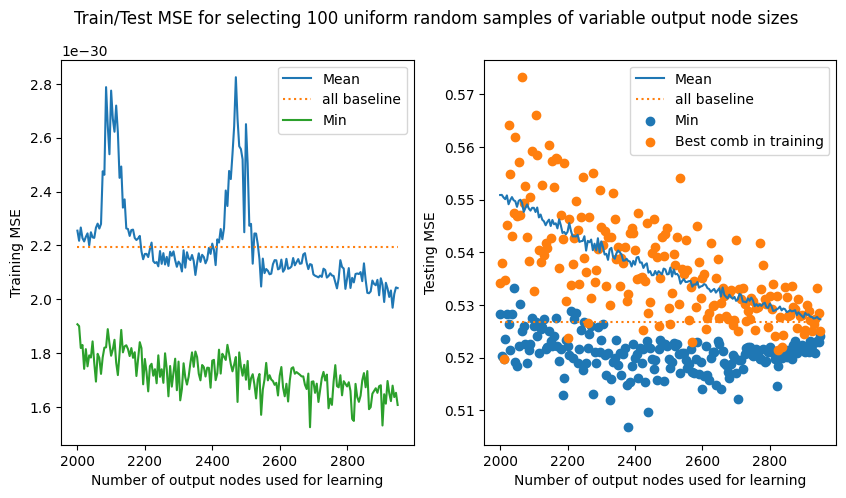

In [106]:
means_tr, means_te = np.array([np.mean(x) for x in overall_tr]),np.array([np.mean(x) for x in overall_te])
mins_tr, mins_te = np.array([np.min(x) for x in overall_tr]),np.array([np.min(x) for x in overall_te])

argmin_trs = [np.argmin(x) for x in overall_tr]
tes_argmintrs = [i[argmin_trs[idx]] for idx, i in enumerate(overall_te)]

fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
node_sample_list = node_sample_list[:len(means_te)]
ax[0].plot(node_sample_list, means_tr, label = 'Mean')
ax[1].plot(node_sample_list, means_te, label = 'Mean')

ax[0].plot(node_sample_list, tr_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')
ax[1].plot(node_sample_list, te_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')

ax[0].plot(node_sample_list, mins_tr, label = 'Min')
ax[1].scatter(node_sample_list, mins_te, label = 'Min')
ax[1].scatter(node_sample_list, tes_argmintrs, label = 'Best comb in training')


ax[0].set_xlabel('Number of output nodes used for learning')
ax[1].set_xlabel('Number of output nodes used for learning')
ax[0].set_ylabel('Training MSE')
ax[1].set_ylabel('Testing MSE')
# ax[1].set_ylim([0, te_mse_all * 2])

ax[0].legend()
ax[1].legend()
# ax[1].set_yscale('log')

fig.suptitle('Train/Test MSE for selecting '+str(REPS)+' uniform random samples of variable output node sizes',
             fontsize=12)

Text(0.5, 0.98, 'Train/Test MSE for selecting 10 uniform random samples of variable output node sizes')

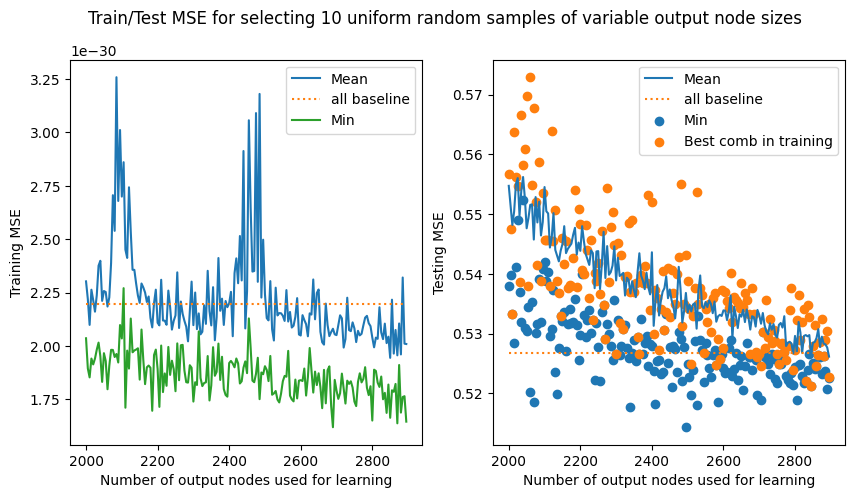

In [100]:
means_tr, means_te = np.array([np.mean(x) for x in overall_tr]),np.array([np.mean(x) for x in overall_te])
mins_tr, mins_te = np.array([np.min(x) for x in overall_tr]),np.array([np.min(x) for x in overall_te])

argmin_trs = [np.argmin(x) for x in overall_tr]
tes_argmintrs = [i[argmin_trs[idx]] for idx, i in enumerate(overall_te)]

fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
node_sample_list = node_sample_list[:len(means_te)]
ax[0].plot(node_sample_list, means_tr, label = 'Mean')
ax[1].plot(node_sample_list, means_te, label = 'Mean')

ax[0].plot(node_sample_list, tr_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')
ax[1].plot(node_sample_list, te_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')

ax[0].plot(node_sample_list, mins_tr, label = 'Min')
ax[1].scatter(node_sample_list, mins_te, label = 'Min')
ax[1].scatter(node_sample_list, tes_argmintrs, label = 'Best comb in training')


ax[0].set_xlabel('Number of output nodes used for learning')
ax[1].set_xlabel('Number of output nodes used for learning')
ax[0].set_ylabel('Training MSE')
ax[1].set_ylabel('Testing MSE')
# ax[1].set_ylim([0, te_mse_all * 2])

ax[0].legend()
ax[1].legend()
# ax[1].set_yscale('log')

fig.suptitle('Train/Test MSE for selecting '+str(REPS)+' uniform random samples of variable output node sizes',
             fontsize=12)

Text(0.5, 0.98, 'Train/Test MSE for selecting 10 uniform random samples of variable output node sizes')

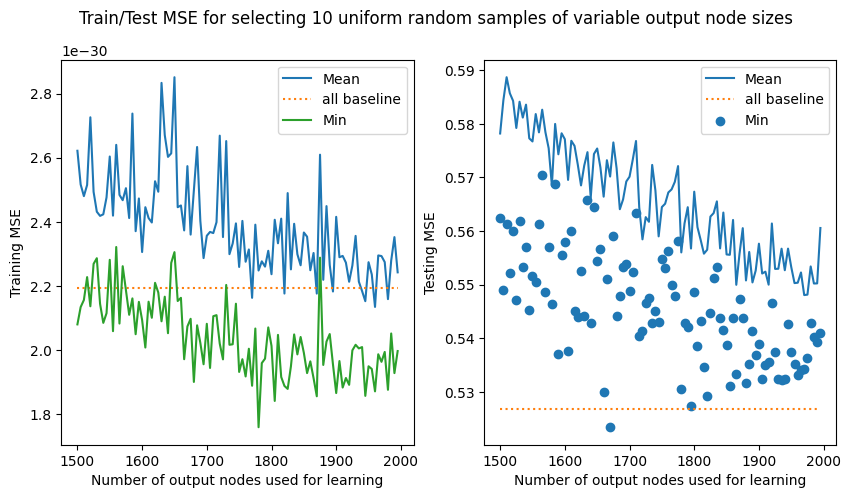

In [94]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))
node_sample_list = node_sample_list[:len(means_te)]
ax[0].plot(node_sample_list, means_tr, label = 'Mean')
ax[1].plot(node_sample_list, means_te, label = 'Mean')

ax[0].plot(node_sample_list, tr_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')
ax[1].plot(node_sample_list, te_mse_all*np.ones(len(node_sample_list)), label = 'all baseline', linestyle = ':')

ax[0].plot(node_sample_list, mins_tr, label = 'Min')
ax[1].scatter(node_sample_list, mins_te, label = 'Min')

ax[0].set_xlabel('Number of output nodes used for learning')
ax[1].set_xlabel('Number of output nodes used for learning')
ax[0].set_ylabel('Training MSE')
ax[1].set_ylabel('Testing MSE')
# ax[1].set_ylim([None, te_mse_all * 2])

ax[0].legend()
ax[1].legend()
# ax[1].set_yscale('log')

fig.suptitle('Train/Test MSE for selecting '+str(REPS)+' uniform random samples of variable output node sizes',
             fontsize=12)

In [50]:
# mean_states_sampled, std_states_sampled = [x.mean() for x in states_sampled], [x.std() for x in states_sampled]
# min_states_sampled, max_states_sampled = [x.min() for x in states_sampled], [x.max() for x in states_sampled]

# mean_states, std_states = [x.mean() for x in states], [x.std() for x in states]
# min_states, max_states = [x.min() for x in states], [x.max() for x in states]

# fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

# ax[0].errorbar(np.arange(len(X)), mean_states, yerr = std_states)
# ax[0].plot(np.arange(len(X)), min_states)
# ax[0].plot(np.arange(len(X)), max_states)

# ax[1].errorbar(np.arange(len(X)), mean_states_sampled, yerr = std_states_sampled)
# ax[1].plot(np.arange(len(X)), min_states_sampled)
# ax[1].plot(np.arange(len(X)), max_states_sampled)